# NAVER Data Science Competition

### 참가자 정보
1. 이름(생년월일): 박선우(19891201)
2. 지원서에 작성한 Edwith ID : psw261@naver.com
3. 팀 정보: 정누리(19900303) / 박선우(19891201)


### 주제: [Kaggle] Home Credit Default Risk 데이터 분석 스케치
- 데이터 출처: https://www.kaggle.com/c/home-credit-default-risk

### 목차: 
    Intro. 배경 이해하기
    Part1. EDA on main datasets
    Part2. Modeling & Validation


### Intro. 배경 이해하기
저희 팀에서 제출할 데이터 분석 스케치에서 다룰 데이터셋은 캐글에서 현재 진행 중인 'Home Credit Default Risk' 대회의 데이터셋입니다.


Home Credit 은 1997년 체코에서 설립된 국제적인 비은행 금융 기관입니다. 14개국에서 운영되고 있으며, 신용기록이 적거나 전혀 없는 사람들을 대상으로한 대출에 중점을 두고있습니다. 보통 신용기록이 없는 사람들은 안정적인 금융권에서 대출을 받는데 어려움이 많아 고리의 대출을 이용하게 됩니다. Home Credit에서는 다양한 대체 데이터(통신 혹은 거래정보 등)와 통계 및 머신러닝 기법을 활용해 고객의 상환 능력을 예측하여 이런 사람들에게도 긍정적인 대출 경험을 제공하려 노력하고 있습니다.

Home Credit은 상환할 수 있는 고객의 대출 신청을 거절하지 않고, 고객이 충분히 상환할 수 있는 적절한 원금, 만기 및 상환일정을 예측하고 싶다고 합니다. 이 대회에서는 7가지 데이터셋이 주어지며, 메인 데이터셋('application_test.csv'와 'application_train.csv')의 target value, 즉 대출 상환에 어려움을 겪을 고객을 예측하는 것이 목표입니다. 

저희는 중심이 되는 application 데이터를 중점적으로 살펴본 후(Part1), 모델링을 통해 최종 예측 결과를 내는 과정(Part2)에 대해 다루고자 합니다. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
%matplotlib inline

## Part1. EDA on main datasets

Application 데이터셋에는 대출 신청자에 대한 기본적인 정보와 상환에 어려움을 겪은 그룹에 대한 정보(target 변수)가 담겨있습니다. Train 데이터셋에는 총 307,511명의 대출신청자(SK_ID_CURR)에 대한 정보가 담겨있으며, 122개의 변수로 구성되어 있습니다. Test 데이터셋에는 총 48,744명에 대한 데이터가 존재하며, Target 변수를 제외한 121개의 변수가 담겨있습니다. 

In [3]:
df1 = pd.read_csv('application_train.csv', index_col = "SK_ID_CURR")
df2 = pd.read_csv('application_test.csv', index_col = "SK_ID_CURR")

In [4]:
df1["DataType"] = "train"
df2["DataType"]= "test"

In [5]:
print(df1.shape)
print(df2.shape)

(307511, 122)
(48744, 121)


### 종속변수 분포 확인하기
#### 교차검증을 위한 데이터 샘플링에 주의하자

Target 변수가 1인 그룹은 대출의 초반 y번의 상환 일정 중에서 최소 한 번 이상 연체가 발생한 그룹입니다. 그 분포를 살펴보면 연체가 발생한 그룹이 전체의 9% 정도로 나타나는 불균형(imbalance) 데이터셋임을 알 수 있습니다. 따라서 교차검증을 위한 샘플링 과정에서 이를 고려할 필요가 있습니다. 이와 관련해서는 SMOTE(Synthetic Minority Over-sampling Technique) 샘플링 방법을 사용할 예정이며, 뒷부분에서 자세히 설명하도록 하겠습니다.

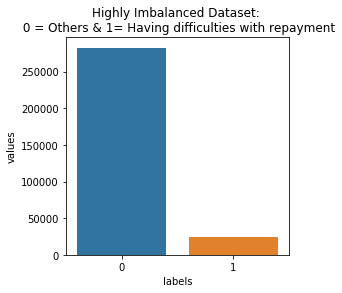

0    282686
1     24825
Name: TARGET, dtype: int64


In [6]:
temp = df1["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,'values': temp.values})
plt.figure(figsize = (4,4))
plt.title('Highly Imbalanced Dataset: \n 0 = Others & 1= Having difficulties with repayment')
sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()
plt.show()
print(df1["TARGET"].value_counts())

### 독립변수의 특성 및 종속변수와의 관계 탐색하기 
데이터 설명서(data description)을 보면 120개가 넘는 변수가 있는데, 설명을 잘 읽어보면 독립변수는 다음과 같은 6가지 범주로 나누어 볼 수 있습니다.

1. 인구통계적 특성
2. 직업 및 소득 관련특성
3. 기본 자산 현황
4. 거주지 관련 특성
5. 외부 신용평가 자료
6. 신청한 대출의 특성

In [7]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df1.head(1)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DataType
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.0,0.069,0.0833,0.125,0.0369,0.0202,0.019,0.0,0.0,0.0252,0.0383,0.9722,0.6341,0.0144,0.0,0.069,0.0833,0.125,0.0377,0.022,0.0198,0.0,0.0,0.025,0.0369,0.9722,0.6243,0.0144,0.0,0.069,0.0833,0.125,0.0375,0.0205,0.0193,0.0,0.0,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,train


In [8]:
df1.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.977752,0.755746,0.044595,0.078078,0.14921

### *Kaggle Kernel에서 참고한 변수 유형별 시각화 함수*
- reference : https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda
- reference의 코드를 참고하여 barplot의 bar 보여주는 순서 설정 추가하는 등의 수정을 하여 활용하였습니다. 
- **plot_stats(feature)**: 명목형 변수 대상으로 사용. 왼쪽 = 전체 데이터에서 category 별 빈도(n), 오른쪽 = 상환되지 않은 대출 중 category 별 비중(%) 표시
- **plot_distribution(feature)**: 연속형 변수 대상
- **def plot_distribution_hue(feature)**: 연속형 변수 대상. target = 1, 0 그룹 나누어서 표시

In [9]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = df1[feature].value_counts()
    df_temp = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})
   # Calculate the percentage of target=1 per category value
    cat_perc = df1[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
   # --> 비율 큰 순서로 막대 순서를 설정해줌. 오히려 헷갈림....???
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts", data=df_temp)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)

    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    s = sns.barplot(ax=ax2, x = feature, y='TARGET',data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
        
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

In [10]:
def plot_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(df1[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()   

In [11]:
def plot_distribution_hue(var):
    sns.kdeplot(df1.loc[df1["TARGET"] == 1, var], label = "Target = 1", shade = True)
    sns.kdeplot(df1.loc[df1["TARGET"] == 0, var], label = "Target = 0", shade = True)
    plt.xlabel(var); plt.ylabel('Density'); plt.title("Distribution of "+var+" by Target")
    plt.show();

---------------

## 1. 인구통계적 특성
다음 여섯 가지 변수는 대출 신청자의 인구통계적 특성을 나타내는 변수로 볼 수 있습니다.


    1.1. 성별 (CODE_GENDER)
    1.2. 연령 (DAYS_BIRTH +  새로운 변수 생성)
    1.3. 가족 구성 (NAME_FAMILY_STATUS, CNT_FAM_MEMBERS, CNT_CHILDREN + 새로운 변수 생성)
    1.4. 교육 수준 (NAME_EDUCATION_TYPE)

In [12]:
v_demo = ['TARGET', 'CODE_GENDER','DAYS_BIRTH','NAME_FAMILY_STATUS', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN', 'NAME_EDUCATION_TYPE']
df1[df1['TARGET'] == 1][v_demo].head(10)

,TARGET,CODE_GENDER,DAYS_BIRTH,NAME_FAMILY_STATUS,CNT_FAM_MEMBERS,CNT_CHILDREN,NAME_EDUCATION_TYPE
SK_ID_CURR,,,,,,,
100002,1,M,-9461,Single / not married,1.0,0,Secondary / secondary special
100031,1,F,-18724,Widow,1.0,0,Secondary / secondary special
100047,1,M,-17482,Married,2.0,0,Secondary / secondary special
100049,1,F,-13384,Civil marriage,2.0,0,Secondary / secondary special
100096,1,F,-24794,Married,2.0,0,Secondary / secondary special
100112,1,M,-10199,Single / not married,1.0,0,Incomplete higher
100130,1,F,-10526,Separated,2.0,1,Incomplete higher
100160,1,M,-16667,Married,2.0,0,Higher education
100181,1,F,-17538,Single / not married,1.0,0,Secondary / secondary special


### 1.1. 성별 (CODE_GENDER)
- 대출은 여자가 더 많이 받으나, 연체자의 비중은 남성 대출자 그룹에서 높은 것으로 나타났습니다. XNA 4명은 모두 연체가 없었고, Revolving Laoan 받은 그룹에 속한 것으로 나타났으며, test set에는 "CODE_GENDER" = "XNA"인 경우 없는 것으로 나타났습니다.

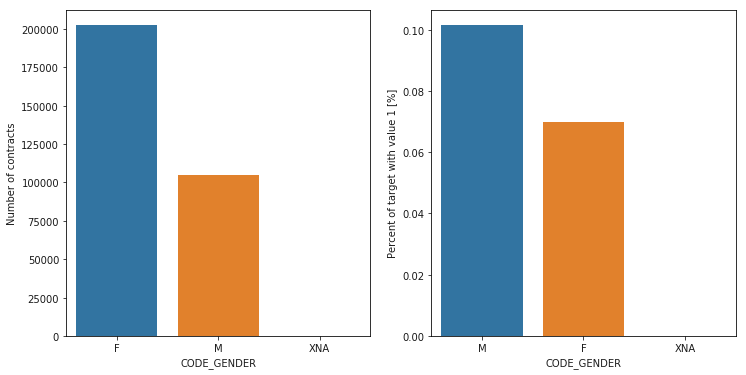

In [13]:
plot_stats('CODE_GENDER')

In [14]:
pd.crosstab(df1["CODE_GENDER"], df1["TARGET"]).apply(lambda r: r/r.sum(), axis=1)

TARGET,0,1
CODE_GENDER,,
F,0.930007,0.069993
M,0.898581,0.101419
XNA,1.000000,0.000000


In [15]:
# df1.loc[df1["CODE_GENDER"] == "XNA"] 
# XNA 4명 모두 TARGET == 0, Revolving Laoan 받은 그룹에 속함

### 1.2. 연령(DAYS_BIRTH)
### 1.2.1. 나이 
- 이 변수는 대출 신청일 기준 대출 신청자의 생일을 뺀 수로, 음수로 표현되는데, 365로 나누고 음수를 양수로 바꾸면, 신청자의 나이를 알 수 있습니다. 연체가 발생한 그룹에서 20대, 30대의 비중이 크게 나타난 것을 확인할 수 있습니다. 

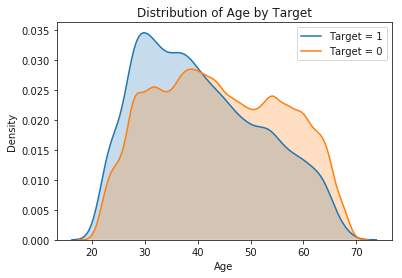

In [16]:
df1["Age"]=-df1["DAYS_BIRTH"]/365
plot_distribution_hue('Age')

### 1.2.2. 연령대(새로운 변수)
나이를 다시 10살씩 나누어 나잇대 그룹을 구성하여 보면, 30대 그룹이 대출을 가장 많이 받았고, 연체 문제 발생 비중은 20대에서 가장 높게 나타난 것을 확인할 수 있습니다. 이처럼 연속형 변수를 명목형 변수로 구성하여 사용할 수 있을 것입니다.

In [17]:
def age_grouping(x):
    if x < 30:
        return 20
    elif x < 40:
        return 30
    elif x < 50:
        return 40
    elif x < 60:
         return 50
    elif x < 70:
         return 60
    return 70
df1['AgeGroup'] = df1['Age'].apply(age_grouping)

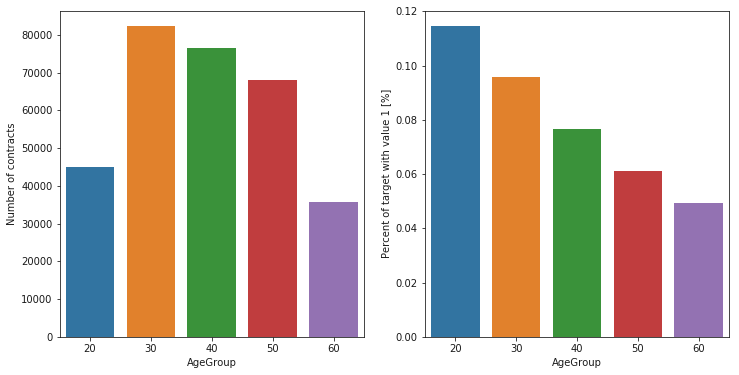

In [18]:
plot_stats('AgeGroup')

### 1.3. 가족 구성(NAME_FAMILY_STATUS, CNT_FAM_MEMBERS, CNT_CHILDREN)
### 1.3.1. 결혼 여부("NAME_FAMILY_STATUS"): 
- 결혼한 사람이 대출을 많이 신청하였는데, 이들은 비교적 대출을 잘 갚는 그룹인 것을 확인할 수 있습니다. 

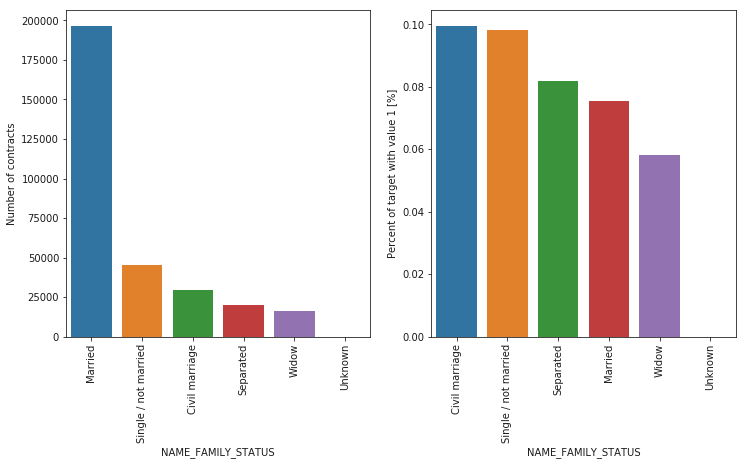

In [19]:
plot_stats('NAME_FAMILY_STATUS',True, True)

### 1.3.2. 가족의 수("CNT_FAM_MEMBERS")와 자녀의 수("CNT_CHILDREN"): 
- 자녀가 없는 사람들이 대출을 신청하는 경우가 매우 많은 것으로 나타났습니다. 자녀가 6명 이하인 경우 상환율은 매우 높았으나(71%~92%) 자녀가 7명 이상인 그룹 중 내에서는 잘 갚는 경우, 못갚는 경우 혼재하는 것으로 나타났습니다. 

In [20]:
# pd.crosstab(df1["CNT_FAM_MEMBERS"], df1["TARGET"]).apply(lambda r: r/r.sum(), axis=1)

In [21]:
# pd.crosstab(df1["CNT_CHILDREN"], df1["TARGET"]).apply(lambda r: r/r.sum(), axis=1)

### 1.3.3. 가족 내 어른의 수(새로운 변수) 
- 더불어 이 두 변수를 조합하여 가족의 수에서 자녀의 수를 뺀 수를 실제 소득활동이 가능한 어른으로 볼 수 있을 것입니다. 전체 대출 신청자 중에는 가족구성원 내 어른이 2명인 대출자가 더 많은 것으로 나타났습니다. 이는 앞서 결혼한 대출자가 많았던 것을 반영한 결과로 볼 수 있습니다. 
한편, 연체 비중은 어른이 1명인 그룹에서 조금 더 높게 나타났습니다. 

In [22]:
df1["CNT_Adults"] = df1["CNT_FAM_MEMBERS"] - df1["CNT_CHILDREN"]

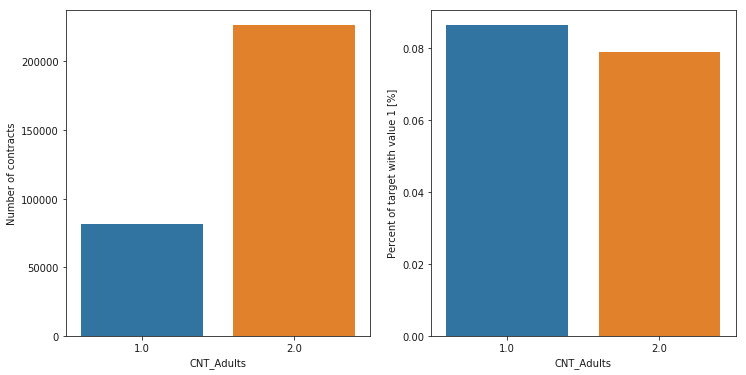

In [23]:
plot_stats('CNT_Adults')

### 1.4. 교육 수준(NAME_EDUCATION_TYPE)
- 전반적으로 중등교육(Secondary / secondary special) 정도의 수준을 받은 사람들이 대출을 많이 신청하는 것을 확인할 수 있습니다. 한편, 연체 비중이 높은 그룹: Incomplete higher, Lower secondary, Secondary / secondary special으로 나타났습니다. 고육 수준이 높은 그룹(Higher education, Academic degree)은 연체 비중 역시 낮은 것으로 나타났습니다. 

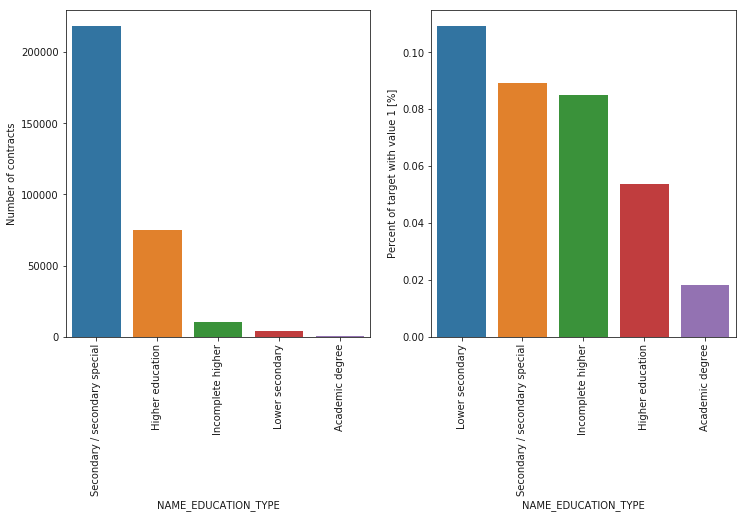

In [24]:
plot_stats('NAME_EDUCATION_TYPE',True)

## 2. 직업 및 소득 관련
120개의 독립변수 중 직업 또는 소득 관련 변수는 다음과 같이 5가지가 있었습니다. 

    2.1. 소득 유형(NAME_INCOME_TYPE)
    2.2. 소득 수준(AMT_INCOME_TOTAL)
    2.3. 직업 유형(OCCUPATION_TYPE)
    2.4. 조직 유형(ORGANIZATION_TYPE)
    2.5. 고용 기간(DAYS_EMPLOYED)

In [25]:
v_jobincome = ['TARGET', 'NAME_INCOME_TYPE', 'AMT_INCOME_TOTAL', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'DAYS_EMPLOYED']
df1[v_jobincome].head()

,TARGET,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,OCCUPATION_TYPE,ORGANIZATION_TYPE,DAYS_EMPLOYED
SK_ID_CURR,,,,,,
100002,1,Working,202500.0,Laborers,Business Entity Type 3,-637
100003,0,State servant,270000.0,Core staff,School,-1188
100004,0,Working,67500.0,Laborers,Government,-225
100006,0,Working,135000.0,Laborers,Business Entity Type 3,-3039
100007,0,Working,121500.0,Core staff,Religion,-3038


### 2.1. 소득 유형(NAME_INCOME_TYPE)
- 미상환비율이 40% 이상인 그룹 위험군(Maternity leave,Unemployed)의 특성을 좀 더 살펴볼 필요가 있겠습니다. 
- 소득 유형이 'Maternity leave'인 그룹은 5명 정도로 매우 적은 케이스였으며 Unemployed 그룹은 "DAYS_EMPLOYED" 변수가 모두 365243로 입력되어있는 특성이 있었는데, 해당 변수를 살펴볼 때 이 점을 주의해야 할 것입니다. 

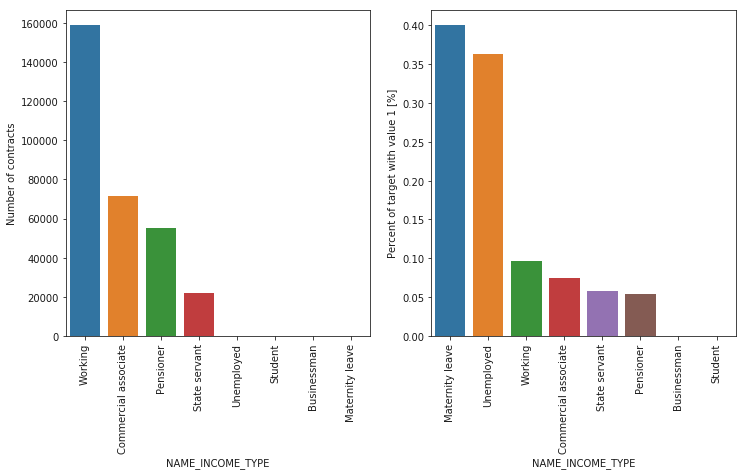

In [26]:
plot_stats('NAME_INCOME_TYPE',True)

In [27]:
df1[df1['NAME_INCOME_TYPE']== 'Maternity leave'][v_jobincome]

,TARGET,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,OCCUPATION_TYPE,ORGANIZATION_TYPE,DAYS_EMPLOYED
SK_ID_CURR,,,,,,
156685,0,Maternity leave,360000.0,NaN,Business Entity Type 1,-3762
227123,0,Maternity leave,135000.0,Core staff,Self-employed,-1223
352877,1,Maternity leave,67500.0,Laborers,Transport: type 2,-3629
437628,1,Maternity leave,49500.0,Core staff,Police,-3020
442305,0,Maternity leave,90000.0,Accountants,Bank,-1550


In [27]:
df1[df1['NAME_INCOME_TYPE']== 'Unemployed'][v_jobincome].head()

,TARGET,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,OCCUPATION_TYPE,ORGANIZATION_TYPE,DAYS_EMPLOYED
SK_ID_CURR,,,,,,
101358,0,Unemployed,337500.0,NaN,XNA,365243
104600,0,Unemployed,135000.0,NaN,XNA,365243
127729,1,Unemployed,99000.0,NaN,XNA,365243
140949,0,Unemployed,56250.0,NaN,XNA,365243
143454,1,Unemployed,31500.0,NaN,XNA,365243


In [29]:
# df1[df1['DAYS_EMPLOYED']== 365243][v_jobincome].head()

### 2.2. 소득 수준 (AMT_INCOME_TOTAL)
- 한쪽으로 매우 치우친 것을 확인할 수 있습니다. 로그 변환하여 살펴보면, 대체로 소득의 큰 차이는 없는 것으로 보입니다. 반면, 매우 소득이 높은 그룹에서는 연체 그룹에 속한 신청자가 있는 것으로 보입니다. 

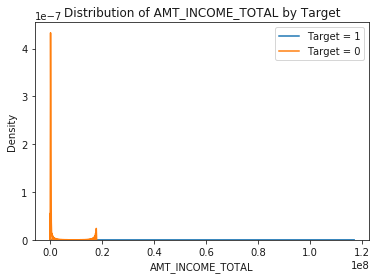

In [30]:
plot_distribution_hue('AMT_INCOME_TOTAL')

In [31]:
df1['ln_AMT_INCOME_TOTAL'] = np.log(df1['AMT_INCOME_TOTAL'])

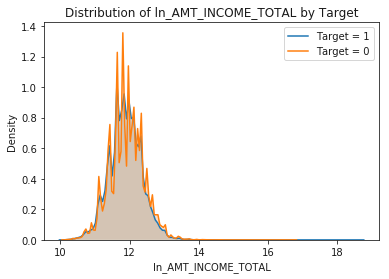

In [32]:
plot_distribution_hue('ln_AMT_INCOME_TOTAL')

### 2.3. 직업 유형(OCCUPATION_TYPE)
- Low-skill Laborers가 전체 대출자에서 차지하는 비중은 많지 않으나, 미상환율은 가장 높은 그룹으로 나타났습니다. 

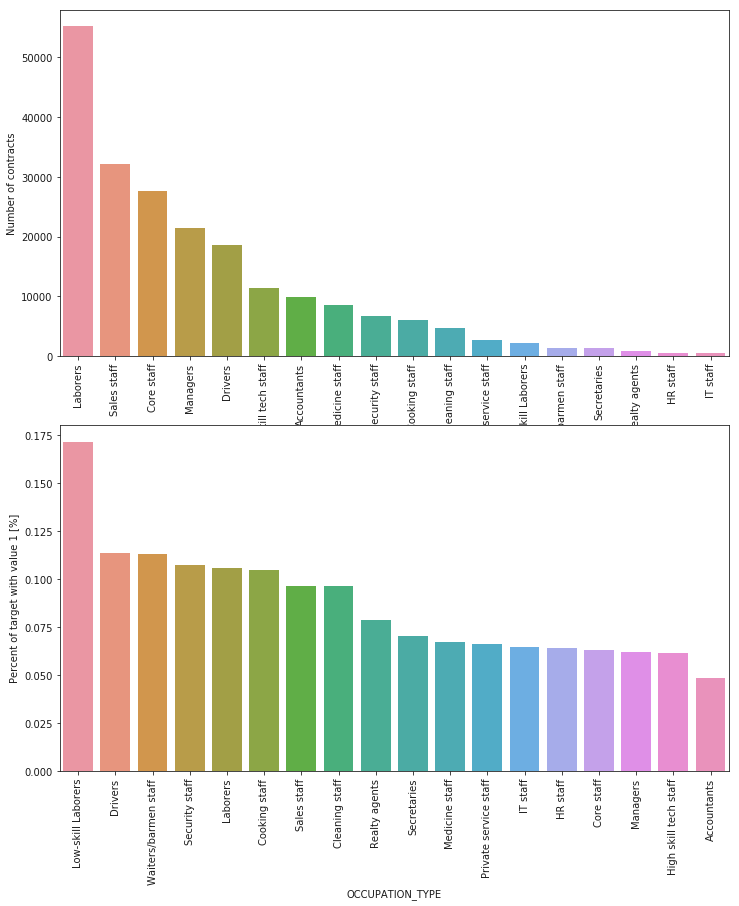

In [33]:
plot_stats('OCCUPATION_TYPE',True, False)

### 2.4. 조직 유형(ORGANIZATION_TYPE)
- 특별히 상환에 문제가 발생하는 그룹이 있는 것은 아니었으나 특이하게도 type3 의 미상환율이 특히 높게 나타났습니다. 해당 업계 내에서도 특히 안정성이 낮은 고용형태를 가지는 그룹이 아닐까 예상해볼 수 있겠습니다.

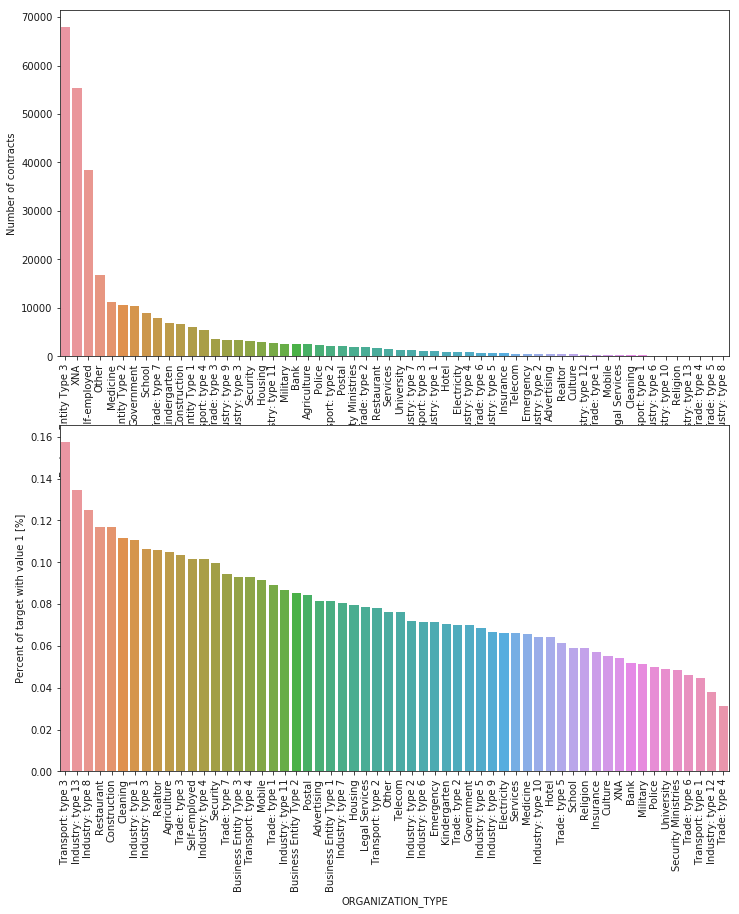

In [37]:
plot_stats('ORGANIZATION_TYPE',True, False)

### 2.5. 고용 기간(DAYS_EMPLOYED)
- "365243"인 그룹은 대체로 "pensioner" 아니면 "unemployed"이었기 때문에, 고용 기간이 의미없는 그룹으로 예상할 수 있습니다. DAYS_BIRTH와 마찬가지로, +로 바꾸고 365로 나누면 근속년수를 계산("Years_EMPLOYED")할 수 있습니다. 
- 연체가 발생한 그룹 중 근속연수가 낮은(7년 이하)의 비율이 높게 나타났습니다.

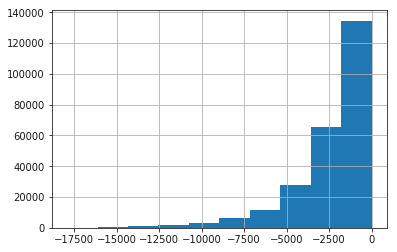

In [42]:
df1[df1["DAYS_EMPLOYED"]<0]["DAYS_EMPLOYED"].hist()

In [49]:
df1["Years_EMPLOYED"]= (-df1['DAYS_EMPLOYED'])/365
# df1["Years_EMPLOYED"].describe()

In [47]:
# plot_distribution_hue('Years_EMPLOYED')

Text(0.5,1,'Density Plot of Years_Employed of working group by Target')

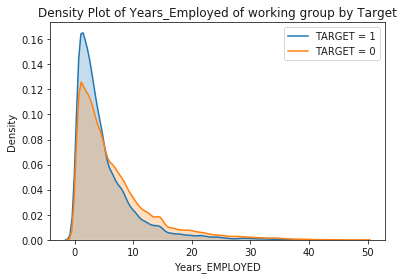

In [48]:
test_working= df1.loc[df1["Years_EMPLOYED"]>=0]
sns.kdeplot(test_working.loc[test_working["TARGET"] == 1, "Years_EMPLOYED"], label = "TARGET = 1", shade = True)
sns.kdeplot(test_working.loc[test_working["TARGET"] == 0, "Years_EMPLOYED"], label = "TARGET = 0", shade = True)
plt.xlabel('Years_EMPLOYED'); plt.ylabel('Density'); plt.title("Density Plot of Years_Employed of working group by Target")

----------------------

## 3. 기본 자산 현황
기본적으로 자산 보유 현황으로는 차량 소유 여부, 부동산 소유 여부, 소유한 차량의 연식 등의 정보가 제공되고 있습니다. 더불어 유형별 연락처 보유 여부도 기본 자산 현황으로 묶어서 분석해보았습니다. 

    3.1. 차량소유 여부(FLAG_OWN_CAR)
    3.2. 부동산 소유 여부(FLAG_OWN_REALTY)
    3.3. 자동차 연식(OWN_CAR_AGE)
    3.4. 연락망(FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL)

### 3.1. 차량 소유 여부 및 3.2. 부동산 소유 여부

- 자동차는 안 가진 경우가 더 많고, 부동산은 가진 경우가 더 많은 것으로 나타났습니다.
- 자산 유무에 따른 상환 문제 발생 여부가 거의 비슷하게 나타났습니다. 다만, 자동차(또는 부동산)가 없는 그룹에서 미상환 비율이 더 높게 나타났습니다.

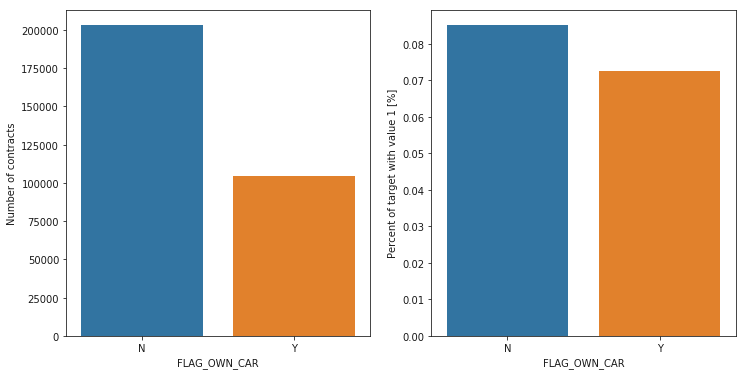

In [191]:
plot_stats('FLAG_OWN_CAR')

In [188]:
# pd.crosstab(df1["FLAG_OWN_CAR"],df1["TARGET"], margins=True)

In [187]:
pd.crosstab( df1["FLAG_OWN_CAR"],df1["TARGET"]).apply(lambda r: r/r.sum(), axis=1)

TARGET,0,1
FLAG_OWN_CAR,,
N,0.914998,0.085002
Y,0.927563,0.072437


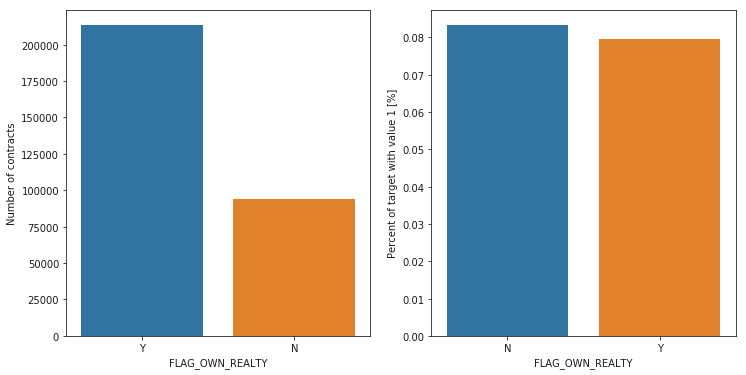

In [192]:
plot_stats('FLAG_OWN_REALTY')

In [193]:
# pd.crosstab(df1["FLAG_OWN_REALTY"], df1["TARGET"], margins=True)

In [190]:
pd.crosstab( df1["FLAG_OWN_REALTY"],df1["TARGET"]).apply(lambda r: r/r.sum(), axis=1)

TARGET,0,1
FLAG_OWN_REALTY,,
N,0.916751,0.083249
Y,0.920384,0.079616


### 자동차 &부동산, 둘 다 가진 경우, 하나라도 있는 경우, 둘 다 없는 경우, 따라 상환율이 다르게 나타나지 않을까요?
- 실제 둘 다 없는 그룹 = 미상환 발생 비율 8.99%로 가장 높게 나타났고, 차가 없고 집이 있는 경우 = 미상환 발생 비율 8.28%,  차가 있고, 집이 없는 경우 = 미상환 발생 비율 7.04%,  둘 다 있는 그룹 = 미상환 발생 비율 7.33%로 나타났습니다. 

In [229]:
test_CR = pd.DataFrame(df1["FLAG_OWN_CAR"])
test_CR["FLAG_OWN_REALTY"] = df1["FLAG_OWN_REALTY"]
test_CR["CARorRealty"] = test_CR["FLAG_OWN_CAR"] + test_CR["FLAG_OWN_REALTY"]
test_CR["TARGET"] = df1["TARGET"]
test_CR= pd.DataFrame(test_CR)

In [230]:
test_CR.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CARorRealty,TARGET
SK_ID_CURR,,,,
100002,N,Y,NY,1.0
100003,N,N,NN,0.0
100004,Y,Y,YY,0.0
100006,N,Y,NY,0.0
100007,N,Y,NY,0.0


In [231]:
pd.crosstab( test_CR["CARorRealty"],test_CR["TARGET"]).apply(lambda r: r/r.sum(), axis=1)

TARGET,0.0,1.0
CARorRealty,,
NN,0.910088,0.089912
NY,0.917156,0.082844
YN,0.929562,0.070438
YY,0.926672,0.073328


In [228]:
# pd.crosstab(test["TARGET"], test["CARorRealty"]).apply(lambda r: r/r.sum(), axis=1)

### 3.3. 자동차 연식
- 기본적으로 자동차의 'AGE'라고 표시가 되어있으나 상식적으로 60년 된 자동차가 있기 어려우므로, 자동차의 연식을 연도가 아닌 '개월 수'로 표현한 것으로 판단됩니다. 10개월 이하 된 연식의 자동차, 즉 신차를 가진 그룹은 상환을 잘 하는 것으로 나타났으나, 10개월 이상 된 연식의 자동차를 가진 그룹은 상환을 잘 못하는 것으로 나타났습니다. 더불어 45개월 이상 된 연식의 자동차를 가진 그룹이 따로 존재하는 것으로 나타났습니다. 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


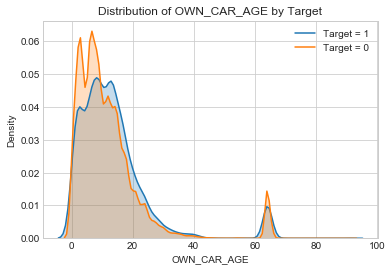

In [286]:
plot_distribution_hue('OWN_CAR_AGE')

### 3.5. 각종 연락망 보유 여부
- FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL 등의 변수가 있었으나, 보유 여부에 따라 상환 여부에 차이는 없는 것으로 나타났습니다. 
- 전체 연락망을 합쳐서 통계치를 내보았는데, 역시 그룹별 연체여부는 비슷하게 나타났습니다. 

In [50]:
# plot_stats('FLAG_MOBIL')

In [51]:
# plot_stats('FLAG_EMP_PHONE')

In [52]:
# plot_stats('FLAG_WORK_PHONE')

In [53]:
# plot_stats('FLAG_CONT_MOBILE')

In [54]:
# plot_stats('FLAG_PHONE')

In [413]:
df1['n_of_contacts'] = df1['FLAG_MOBIL']+df1['FLAG_EMP_PHONE']+df1['FLAG_WORK_PHONE']+df1['FLAG_CONT_MOBILE']+df1['FLAG_PHONE']+df1['FLAG_EMAIL']
df1['n_of_contacts'].describe()

count    307511.000000
mean          3.355174
std           0.865288
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: n_of_contacts, dtype: float64

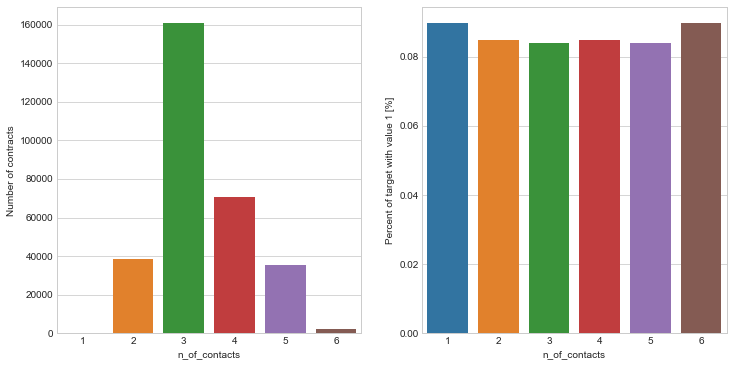

In [414]:
plot_stats('n_of_contacts')

----------------------------

## 4. 거주지 관련

- 보유한 집의 특성에 대해서는 APARTMENTS, BASEMENTAREA, COMMONAREA, ELEVATORS, ENTRANCES, FLOORSMAX, FLOORSMIN, LANDAREA, LIVINGAPARTMENTS, LIVINGAREA, NONLIVINGAPARTMENTS , NONLIVINGAREA, YEARS_BEGINEXPLUATATION, YEARS_BUILD 등의 특성으로 나누어 표현하고 있으며, 각 변수는 AVG, MEDI, MODE 세 가지 값을 가집니다. 그 외에 TOTALAREA_MODE(연속형), FONDKAPREMONT_MODE(범주형) HOUSETYPE_MODE(범주형), WALLSMATERIAL_MODE(범주형) 변수는 MODE값만 존재하는 것으로 나타났습니다. 
- 거주지 관련 변수는 결측치가 매우 많아 유의미한 정보를 찾기가 어려운 것으로 판단되며, 향후 모델링에 있어서 유의할 필요가 있겠습니다. 

## 4. 대출 신청 관련
    4.1. 대출 당시 동반자(NAME_TYPE_SUITE)
    4.2. 대출 신청 규모(AMT_CREDIT, AMT_ANNUITY)
    4.3. 대출 당시 제출 서류수

### 4.1. 대출 당시 동반자(NAME_TYPE_SUITE)
- 대체로 혼자 온 신청자가 많았는데 그룹 별 연체자의 비중은 크지 않은 것으로 나타났습니다. 

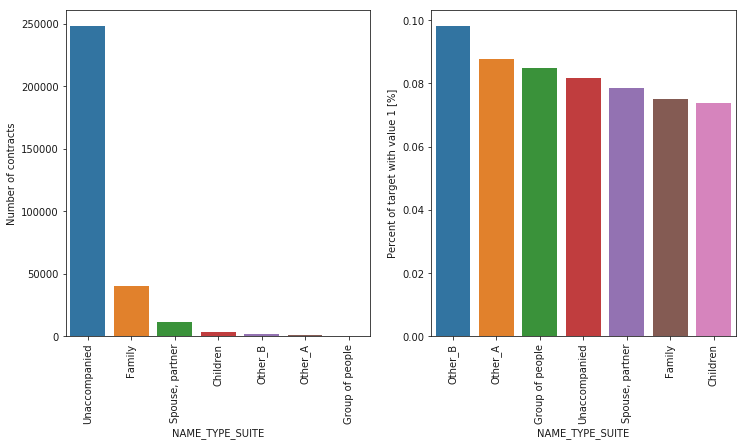

In [56]:
plot_stats("NAME_TYPE_SUITE", True)

### 4.2. 대출 신청 규모(AMT_CREDIT, AMT_ANNUITY)
- 대출 신청 규모역시 두 그룹의 분포가 비슷하게 나타나, 영향력있는 변수가 아닌 것으로 판단됩니다. 

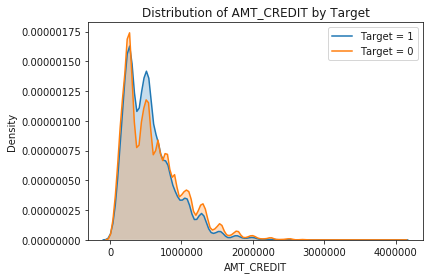

In [57]:
plot_distribution_hue('AMT_CREDIT')

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


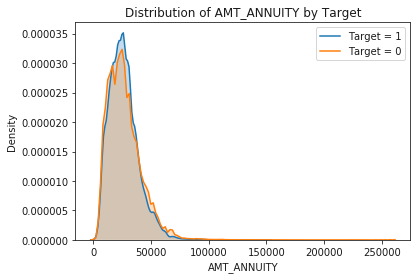

In [59]:
plot_distribution_hue('AMT_ANNUITY')

## 5. 외부 신용평가 자료
    5.1. 외부 데이터의 점수(EXT_SOURCE_1 ~ 3)
    5.2. CreditBureau 과거 기록

### 5.1. 외부평가 점수(EXT_SOURCE_1~3)
- 본 데이터셋에는 대출자에 대한 외부 평가 점수가 3 가지로 제공되는데, 연체가 발생한 그룹과 그렇지 않은 그룹에서 세 점수 모두 뚜렷한 차이가 나타났습니다. 신청자에 대한 과거 신용 거래정보를 종합적으로 판단하여 계산된 점수일 것으로 예상됩니다. 
- 향후 모델링에서도 두 그룹을 구분하는 데 중요한 변수로 작용할 것으로 보입니다. 

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


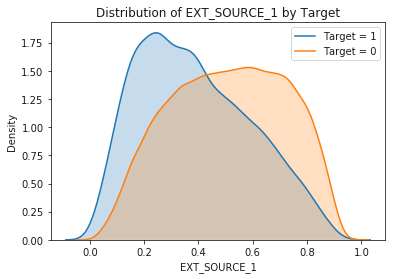

In [60]:
plot_distribution_hue('EXT_SOURCE_1')

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


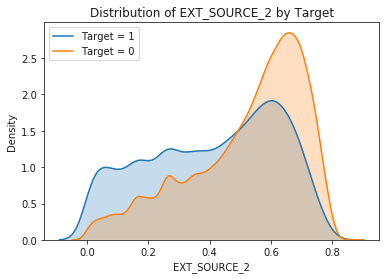

In [61]:
plot_distribution_hue('EXT_SOURCE_2')

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


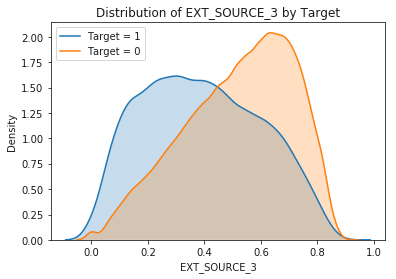

In [62]:
plot_distribution_hue('EXT_SOURCE_3')

### 5.2. CreditBureau 과거 기록
- AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR 등의 변수가 있었는데, 몇 가지를 살펴보면 그룹간 차이가 크지 않아 유의미하지 않은 변수들로 판단됩니다. 

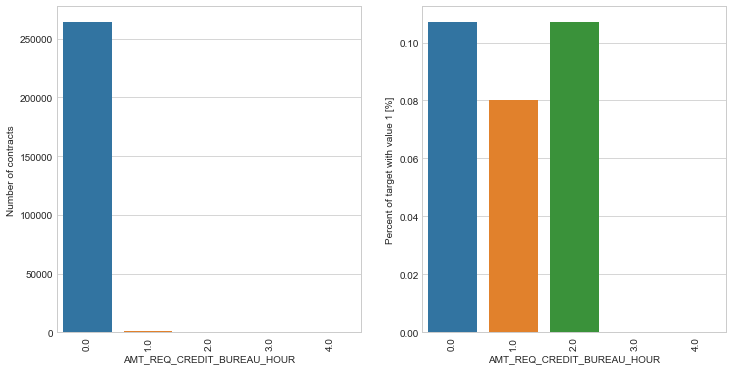

In [398]:
plot_stats('AMT_REQ_CREDIT_BUREAU_HOUR', True, True)

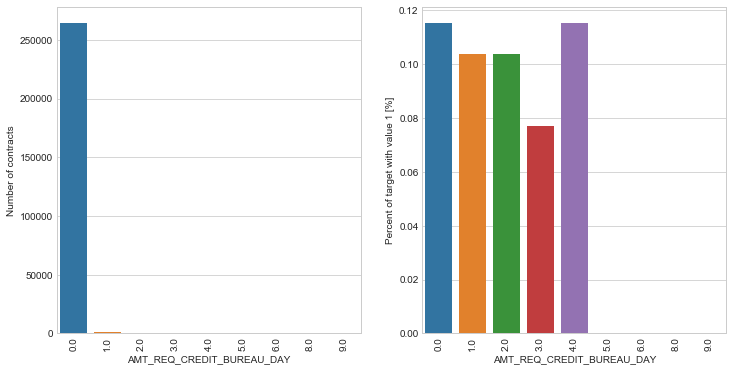

In [397]:
plot_stats('AMT_REQ_CREDIT_BUREAU_DAY', True, True)

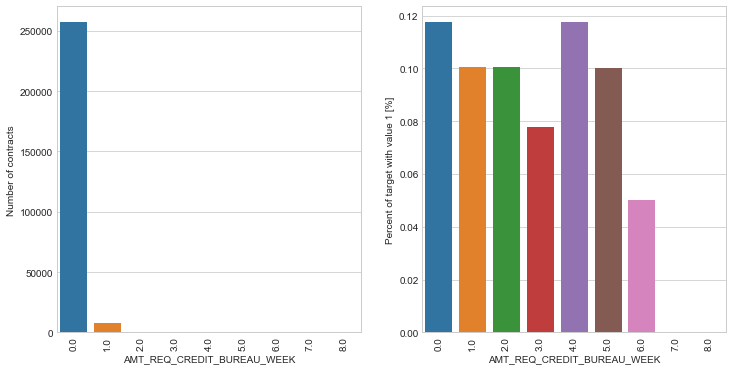

In [399]:
plot_stats('AMT_REQ_CREDIT_BUREAU_WEEK', True, True)

아래 그래프는 과거대출의 계약상태를 나타내는 변수를 비교한 것으로 전체횟수에서 거절된 횟수의 비중을 나타냅니다<br>
상환(target 0)인 경우 해당변수가 0에 몰려있으나, 미상환인 경우에는 0에 있는 비중이 상대적으로 낮고 거절비중이 좀 더 높습니다<br>
과거대출을 신청했을때 거절된 비율이 높을수록, 대출기준을 만족하지 못함, 현재대출을 상환하지 못할 확률도 높게나타난다고 설명할 수 있습니다<br>

The correlation between previous_loans_NAME_CONTRACT_STATUS_Refused_count_norm and the TARGET is 0.0777
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


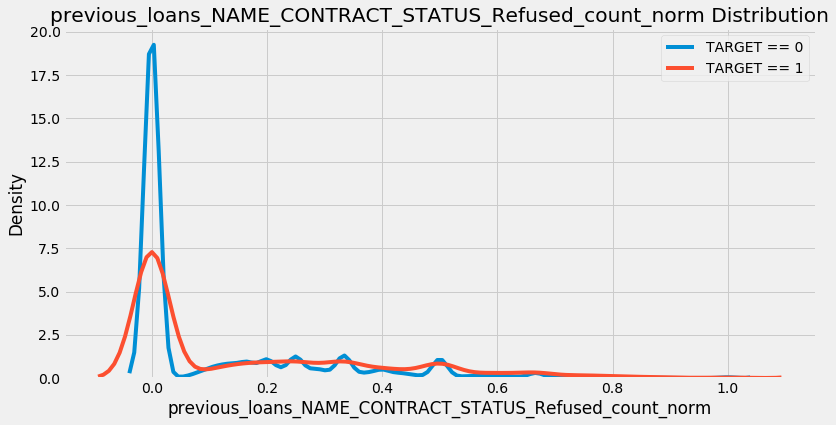

In [96]:
kde_target(var_name='previous_loans_NAME_CONTRACT_STATUS_Refused_count_norm', df=train)

## Part2. Modeling & Validation

### Logistic Regression

모델을 수행하기전에 결측치를 채우고, 특성들을 scaling 하는 전처리 작업을 수행합니다<br>
scikit-learn에 있는 LogisticRegression 모델을 사용합니다<br>

In [30]:
from sklearn.preprocessing import MinMaxScaler, Imputer

if 'TARGET' in app_train:
    train = app_train.drop(columns= ['TARGET'])
else :
    train = app_train.copy()
    
features = list(train.columns)

test = app_test.copy()
imputer = Imputer(strategy='median')
scaler = MinMaxScaler(feature_range=(0,1))
imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(app_test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


In [31]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C= 0.0001)
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

regularization parameter, C를 디폴트값보다 낮게 설정하였습니다. 해당값이 낮을수록 overfitting을 낮추는 기능을 합니다<br><br>
우리는 상환하지 않을 확률을 예측하는 것이 목표이기에 predict.proba 메서드를 사용했습니다<br>
m * 2 배열 형태로 결과값이 나오고 첫번째 컬럼은 상환할 확률(target 0), 두번째 컬럼은 미상환할 확률(target 1)을 나타냅니다

In [32]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [33]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred
submit.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SK_ID_CURR,TARGET
0,100001,0.087895
1,100005,0.163376
2,100013,0.110105
3,100028,0.076499
4,100038,0.155235


구분할 각 분류에 해당하는 데이터의 비율이 반반이 아닌 경우 훈련 데이터 내 비율이 높은 분류 쪽으로 결과를 내놓는 모델을 만들게 될 수 있습니다.<br> 
이런 상황을 클래스 불균형(class imbalance)이라고 하며 이를 해결하는 방법으로 가중치(weight)를 조절하거나,<br> 
더 많은 비용(cost)을 부과하거나, 훈련 데이터를 직접 조절하는 방법이 있습니다(SMOTE).<br>
SMOTE는 비율이 낮은 분류의 데이터를 고려하여 샘플을 만들어 내는 방법입니다.<br> 
기존의 샘플을 주변의 이웃을 고려해 약간씩 이동시킨 점들을 추가하는 방식으로 동작합니다.<br><br>

AUC = AUROC (the Area Under a ROC Curve) : ROC 커브의 밑면적을 구한 값이 바로 AUC입니다.<br> 
이 값이 1에 가까울수록 성능이 좋은 것으로 판단할 수 있습니다. 1로 예측하는 기준을 쉽게 잡으면 민감도는 높아지는 대신 모든 경우를 1이라고 하므로,<br> 
특이도가 낮아집니다. 그러므로 이 두 값이 둘 다 1에 가까워야 의미가 있습니다.<br> 
민감도와 특이도는 서로 트레이드오프(trade off) 관계로 두 값의 합은 항상 1 입니다.<br> 
AUC 값은 전체적인 민감도와 특이도의 상관 관계를 보여줄 수 있어 편리한 성능 척도 기준입니다.<br>

### LightGBM

그래디언트 부스팅은 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가합니다. 이전 예측기가 만든 잔여오차에 새로운 예측기를 학습하는 방식입니다.<br><br>

모델에 들어갈 다양한 변수들을 생성하기 위해 공통함수로 다음 3개를 이용했습니다<br>
agg_numeric (수치형 데이터에서 count, mean, max, min, sum 기본통계를 계산)<br>
count_categorical (범주형 데이터에서 counts and normalized counts 계산)<br>
aggregate_client ( agg_numeric(), count_categorical() 두 개 함수를 이용하여 데이터셋을 정리)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import gc

from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from lightgbm import LGBMClassifier

In [2]:
def agg_numeric(df, group_var, df_name):
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    columns = [group_var]

    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))
    agg.columns = columns
    return agg

In [3]:
def count_categorical(df, group_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    column_names = []

    for var in categorical.columns.levels[0]:
        for stat in ['count', 'count_norm']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    return categorical

In [4]:
def aggregate_client(df, group_vars, df_names):
    
    df_agg = agg_numeric(df, group_var = group_vars[0], df_name = df_names[0])
    
    if any(df.dtypes == 'object'):
        df_counts = count_categorical(df, group_var = group_vars[0], df_name = df_names[0])
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')
        gc.enable()
        del df_agg, df_counts
        gc.collect()

        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
       
    else:
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        gc.enable()
        del df_agg
        gc.collect()
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
        
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

build_model_input()에서 각각의 데이터셋별로 키값을 중심으로 train, test 데이터셋과 merge 하는 작업을 진행합니다

In [11]:
def build_model_input():    

    print('Read data and test')
    train = pd.read_csv('../4th_week/data/application_train.csv')
    test = pd.read_csv('../4th_week/data/application_test.csv')
    print('Shapes : ', train.shape, test.shape)
    
    y = train['TARGET']
    del train['TARGET']  
    
    categorical_feats = [
        f for f in train.columns if train[f].dtype == 'object'
    ]
    categorical_feats
    for f_ in categorical_feats:
        train[f_], indexer = pd.factorize(train[f_])
        test[f_] = indexer.get_indexer(test[f_])
    
    print('Read bureau_balance')
    buro_bal = pd.read_csv('../4th_week/data/bureau_balance.csv')
    buro_bal = pd.concat([buro_bal, pd.get_dummies(buro_bal.STATUS, prefix='buro_bal_status')], axis=1).drop('STATUS', axis=1)
    buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
    buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])

    avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()
    avg_buro_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]
    
    del buro_bal
    gc.collect()

    print('Read Bureau')
    buro = pd.read_csv('../4th_week/data/bureau.csv')
    buro_credit_active_dum = pd.get_dummies(buro.CREDIT_ACTIVE, prefix='ca_')
    buro_credit_currency_dum = pd.get_dummies(buro.CREDIT_CURRENCY, prefix='cu_')
    buro_credit_type_dum = pd.get_dummies(buro.CREDIT_TYPE, prefix='ty_')
    buro_full = pd.concat([buro, buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum], axis=1)
 
    del buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum
    gc.collect()

    print('Merge with buro avg')
    buro_full = buro_full.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))

    print('Counting buro per SK_ID_CURR')
    nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
    buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])

    print('Averaging bureau')
    bureau_by_client = buro_full.groupby('SK_ID_CURR').mean()

    del buro, buro_full
    gc.collect()

    train = train.merge(bureau_by_client, on = 'SK_ID_CURR', how = 'left')
    test = test.merge(bureau_by_client, on = 'SK_ID_CURR', how = 'left')
    
    gc.enable()
    del bureau_by_client
    gc.collect()
    
    print('Read prev')
    previous = pd.read_csv('../4th_week/data/previous_application.csv')
    previous_by_client = aggregate_client(previous, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['previous', 'client'])
    
    train = train.merge(previous_by_client, on = 'SK_ID_CURR', how = 'left')
    test = test.merge(previous_by_client, on = 'SK_ID_CURR', how = 'left')
    
    gc.enable()
    del previous, previous_by_client
    gc.collect()
        
    print('Reading POS_CASH')
    cash = pd.read_csv('../4th_week/data/POS_CASH_balance.csv')
    cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
    
    train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
    test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

    gc.enable()
    del cash, cash_by_client
    gc.collect()
    
    print('Reading CC balance')
    credit = pd.read_csv('../4th_week/data/credit_card_balance.csv')
    credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])

    train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
    test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
    
    gc.enable()
    del credit, credit_by_client
    gc.collect()
    
    print('Reading Installments')
    installments = pd.read_csv('../4th_week/data/installments_payments.csv')
    installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
    
    train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
    test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

    gc.enable()
    del installments, installments_by_client
    gc.collect()
        
    return train, test, y

train_model()에서는 lightgbm의 LGBMClassifier에 복수의 test set을 준비하는 KFold (여기서는 5Fold)를 사용하여 모델을 훈련시킵니다

In [6]:
def train_model(data_, test_, y_, folds_):

    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    
    feature_importance_df = pd.DataFrame()
    
    feats = [f for f in data_.columns if f not in ['SK_ID_CURR']]
    
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            subsample_freq=1,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            random_state=0,
            silent=-1,
            verbose=-1, )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=200  #100
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['TARGET'] = sub_preds

    return oof_preds, test_[['SK_ID_CURR', 'TARGET']], feature_importance_df

In [7]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances_0729.png')

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.754941	valid_1's auc: 0.742518
[200]	training's auc: 0.781215	valid_1's auc: 0.762854
[300]	training's auc: 0.799578	valid_1's auc: 0.774897
[400]	training's auc: 0.81181	valid_1's auc: 0.7807
[500]	training's auc: 0.821312	valid_1's auc: 0.783602
[600]	training's auc: 0.829364	valid_1's auc: 0.785406
[700]	training's auc: 0.837012	valid_1's auc: 0.786683
[800]	training's auc: 0.843534	valid_1's auc: 0.787354
[900]	training's auc: 0.849542	valid_1's auc: 0.787968
[1000]	training's auc: 0.855169	valid_1's auc: 0.788204
[1100]	training's auc: 0.860966	valid_1's auc: 0.788534
[1200]	training's auc: 0.866158	valid_1's auc: 0.788726
[1300]	training's auc: 0.871372	valid_1's auc: 0.788617
Early stopping, best iteration is:
[1184]	training's auc: 0.865398	valid_1's auc: 0.788746
Fold  1 AUC : 0.788746
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.754358	valid_1's auc

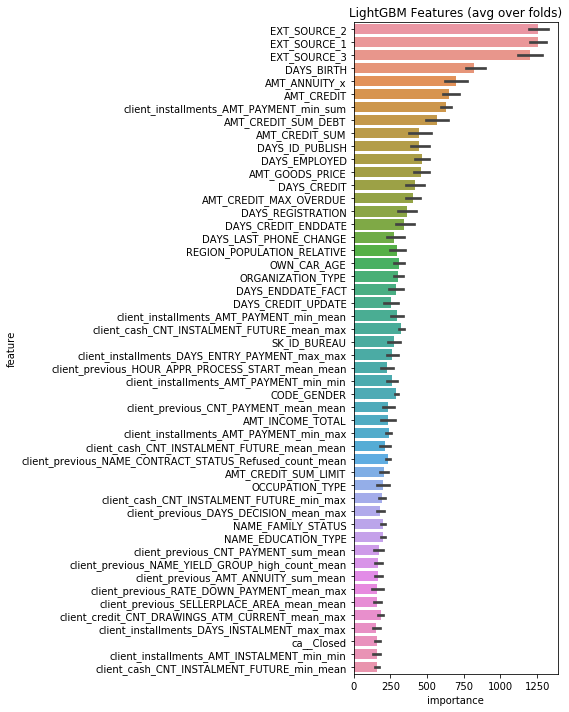

In [16]:
if __name__ == '__main__':
    gc.enable()
    data, test, y = build_model_input()
    folds = KFold(n_splits=5, shuffle=True, random_state=546789)
    oof_preds, test_preds, importances = train_model(data, test, y, folds)
    test_preds.to_csv('lightGBM_aggregate_0729.csv', index=False)
    folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in folds.split(data)]
    display_importances(feature_importance_df_=importances)

모델 훈련결과 0.787044 로 비교적 높은 결과값이 나왔습니다<br>
display_importances() 함수를 사용해서 모델에 미치는 영향력이 높은 상위50개 특성을 display 해보았습니다<br>
중요도가 높게 나온 특성중에 유의미한 것이 있다면 다시 이부분부터 데이터 탐색을 시작해야할 것 같습니다<br>